In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Выполните стандартизацию для набора данных вина (`wine_data`), используя только базовый python, numpy и pandas (вообще не используя `StandardScaler` и sklearn). Реализация функции (или класса), которая может получать набор данных в качестве входных данных и возвращать стандартизированный набор данных в качестве выходных данных, предпочтительна, но не обязательна.

Сравните свои результаты (вывод) с `StandardScaler`.

**ПРИМЕЧАНИЕ:**

- 1 балл за функциональную версию, 2 балла за реализацию масштабирования как класс, совместимый с конвейером sklearn.
- Максимум за упражнение 2 балла.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    return (X - np.mean(X)) / np.std(X)

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        self.columns = columns
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):
        if self.with_mean:
            self.mean = np.mean(X)
        else:
            self.mean = 1
        if self.with_std:
            self.std = np.std(X)
        else:
            self.std = 1
        return self

    def transform(self, X, y=None, copy=None):
        return (X - self.mean) / self.std

In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-11.63468676,  -1.29757921],
       [ -0.66004939,   0.67475101],
       [-21.49633462,  -2.24288738],
       ...,
       [ -2.38858161,   5.71673796],
       [  5.11264094,   5.03575232],
       [ -7.59546544,   2.42232676]])

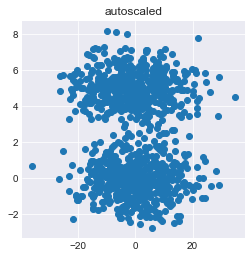

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='autoscaled')

**ПРИМЕЧАНИЕ:** на приведенном выше графике оси масштабируются по-разному, и мы можем ясно видеть два потенциальных *класса/кластера*. На самом деле `matplotlib` выполнил `autoscaling` (которое в основном можно рассматривать как `MinMaxScaling` исходных данных) просто для лучшей визуализации.

Давайте отключим эту функцию и визуализируем исходные данные на графике с одинаково масштабированными осями: 

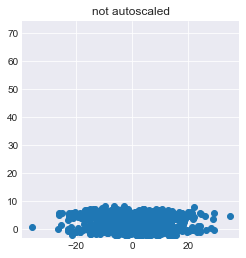

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='not autoscaled')

Эта картина явно менее интерпретируема, но гораздо ближе к тому, «как алгоритм на основе расстояния видит исходные данные»: разделимость данных едва заметна только потому, что вариация (std) x-признака намного больше в абсолютных числах.

Выполните `StandardScaling` и `MinMaxScaling` исходных данных; визуализировать результаты для каждого случая (**используйте `plot_scatter` с `auto_scaled=False`**): 

### MinMaxScaling (0.5 point)

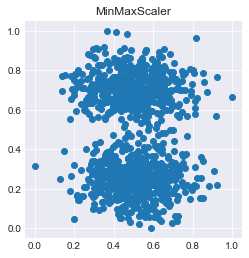

In [12]:
data = MinMaxScaler().fit_transform(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='MinMaxScaler')

### StandardScaler (0.5 point)

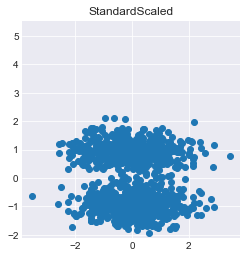

In [13]:
data = StandardScaler().fit_transform(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='StandardScaled')

### (Bonus) K-means (2 points)

Проиллюстрируйте влияние масштабирования на базовый алгоритм кластеризации на основе расстояния [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1), используя «данные», сгенерированные выше.

**ПРИМЕЧАНИЕ:** в принципе, здесь вам не нужно понимать алгоритм K-средних, вам просто нужно:

1) запустить алгоритм (при k=2, k - количество кластеров/классов) на немасштабированных данных

2) запустить алгоритм (с k=2) на масштабированных данных

3) результаты построения: выделите разные кластеры разными цветами.

Вы можете использовать этот [вопрос] (https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) в качестве подсказки, но я рекомендую вам построить результаты с использованием `plot_scatter` с `equal_scaled=True`: это может помочь вам интуитивно понять причины такого влияния масштабирования. 


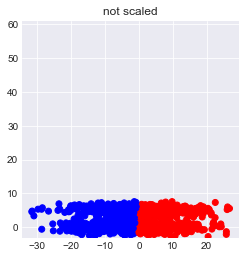

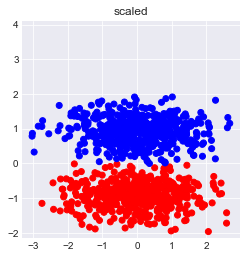

In [14]:
from sklearn.cluster import KMeans
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
km = KMeans(2)
data_pred = km.fit_predict(data)
data_w = StandardScaler().fit_transform(data)
data_w_pred = km.fit_predict(data_w)
plot_scatter(x=data[:, 0], y=data[:, 1], clusters=data_pred, auto_scaled = False, title='not scaled')
plot_scatter(x=data_w[:, 0], y=data_w[:, 1], clusters=data_w_pred, auto_scaled = False, title='scaled')

## Exercise  3 - Preprocessing Pipeline (2 points)

In [15]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Обучить модель (например, `LogisticRegression(solver='liblinear', Penal='l1')` на необработанных данных `wine_train`; затем обучить ту же модель после масштабирования данных; затем добавить выбор функций (и снова обучить модель на масштабированных данных) , Для каждого эксперимента все необходимые шаги предварительной обработки (если они есть) должны быть включены в конвейер sklearn.

Измерьте «точность» всех трех подходов к набору данных «wine_val». Опишите и объясните результаты.

In [16]:
def model_sca():
    regressor = LogisticRegression(solver='liblinear', penalty='l1')
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])
def model_f_s():
    regressor = LogisticRegression(solver='liblinear', penalty='l1')
    return Pipeline([
        ('f_s', VarianceThreshold(threshold=(0.3))), 
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score

model = LogisticRegression(solver='liblinear', penalty='l1')
print('Модель без скалирования : test :', accuracy_score(model.fit(wine_train, wine_labels_train).predict(wine_val), wine_labels_val))
print('Модель без скалирования : train :', accuracy_score(model.fit(wine_train, wine_labels_train).predict(wine_train), wine_labels_train))
print('Модель со скалированием : test :', accuracy_score(model_sca().fit(wine_train, wine_labels_train).predict(wine_val), wine_labels_val))
print('Модель со скалированием : train :', accuracy_score(model_sca().fit(wine_train, wine_labels_train).predict(wine_train), wine_labels_train))
print('Модель со скалированием и выбором фич: test :', accuracy_score(model_f_s().fit(wine_train, wine_labels_train).predict(wine_val), wine_labels_val))
print('Модель со скалированием и выбором фич: train :', accuracy_score(model_f_s().fit(wine_train, wine_labels_train).predict(wine_train), wine_labels_train))

Модель без скалирования : test : 0.9814814814814815
Модель без скалирования : train : 0.967741935483871
Модель со скалированием : test : 0.9814814814814815
Модель со скалированием : train : 1.0
Модель со скалированием и выбором фич: test : 1.0
Модель со скалированием и выбором фич: train : 0.967741935483871


## Упражнение 4 - ручная PCA (5 баллов)
Задача состоит в том, чтобы решить PCA как задачу оптимизации без явного разложения по собственным значениям.
В самом общем случае PCA есть минимизация ошибки восстановления проекции заданного ранга $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i|| ^2$$

С помощью ряда шагов, которые можно найти здесь https://stats.stackexchange.com/a/10260, эта задача превращается в
  $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
  где $\mathbf{S}$ — выборочная ковариационная матрица (после стандартизации), а $u_1, \ldots, u_q$ — $q$ — ортонормированные столбцы в $\mathbf{V}_q$.
  Давайте решим эту задачу оптимизации с помощью библиотеки `scipy.optimize`.
 
  Дополнительные 2 балла даются за визуализацию результатов.

### PCA (3 points)

In [18]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Найдите ковариационную матрицу стандартизированных данных и присвойте ее S.

In [236]:
x = CustomScaler().fit_transform(wine_data).T

In [240]:
S = (x@x.T)/(x.shape[1]-1)

Если ваш код правильный, следующее утверждение должно быть в порядке.

In [241]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [242]:
np.linalg.norm(S)

5.787241159764734

In [180]:
S

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,0.967525,0.078880,0.179107,-0.325260,0.240792,0.253166,0.201794,-0.166905,0.104111,0.521975,-0.095232,0.042760,0.608208
malic_acid,0.078880,1.001441,0.148566,0.290433,-0.067624,-0.354145,-0.429070,0.298959,-0.236375,0.241554,-0.567823,-0.381336,-0.210565
ash,0.179107,0.148566,0.967600,0.428379,0.256618,0.093081,0.080093,0.175292,-0.022897,0.234535,-0.098114,-0.025634,0.188152
alcalinity_of_ash,-0.325260,0.290433,0.428379,1.002425,-0.095890,-0.339599,-0.368941,0.368396,-0.212464,0.011792,-0.279990,-0.288902,-0.458659
magnesium,0.240792,-0.067624,0.256618,-0.095890,0.972462,0.180934,0.163231,-0.264801,0.206322,0.178029,0.034382,0.038889,0.360307
total_phenols,0.253166,-0.354145,0.093081,-0.339599,0.180934,0.960604,0.826082,-0.464371,0.576366,-0.082986,0.406736,0.666906,0.459142
flavanoids,0.201794,-0.429070,0.080093,-0.368941,0.163231,0.826082,0.962432,-0.551421,0.617559,-0.199315,0.517447,0.755064,0.456135
nonflavanoid_phenols,-0.166905,0.298959,0.175292,0.368396,-0.264801,-0.464371,-0.551421,1.010524,-0.376932,0.136167,-0.264625,-0.511353,-0.325398
proanthocyanins,0.104111,-0.236375,-0.022897,-0.212464,0.206322,0.576366,0.617559,-0.376932,0.967302,-0.049751,0.271948,0.489372,0.294793
color_intensity,0.521975,0.241554,0.234535,0.011792,0.178029,-0.082986,-0.199315,0.136167,-0.049751,0.983696,-0.537213,-0.450313,0.288674


In [60]:
from scipy.optimize import minimize

def objective(x):
    # your code: напишите цель проблемы (не забывайте, что scipy делает min, а нам нужно max)
    return 1 - x.T@S@x
    
def norm_constraint(x): 
    # your code: Ограниченная норма x равна 1, функция должна возвращать 0, если ограничение выполняется 
    if np.linalg.norm(x) == 1:
        return 0
    else:
        return 1 - x.T @ x
    
con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.ones(wine_data.shape[1])

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [61]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    if (x.T @ x0 == 0):
        return 0
    else:
        return - x.T @ x0

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.ones(wine_data.shape[1])


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [62]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Визуализируйте точки после применения пользовательского уменьшения размеров с 2 компонентами.

In [63]:
wine_data = StandardScaler().fit_transform(wine_data)

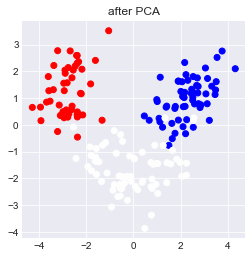

In [64]:
plot_scatter(x=wine_data @ x0, y=wine_data @ x1, clusters=wine_labels, auto_scaled = True, title='after PCA')

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [65]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

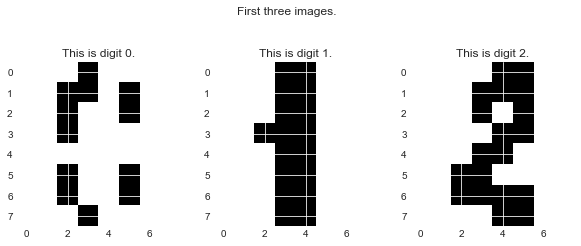

In [66]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [68]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [69]:
clf = RandomForestClassifier(max_depth=13)

# your code here

acc = f1_score(clf.fit(X_train, y_train).predict(X_val), y_val, average='micro')
print(acc)

0.9814814814814815


In [70]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [71]:
#! pip install boruta

In [72]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

# your code here: do run the boruta
feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x160ADC94A40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x160ADC94A40)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

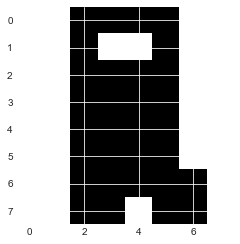

In [73]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask)

At the end let us redo  classification but only with selected features

In [77]:
clf = RandomForestClassifier(max_depth=13)

acc = f1_score(clf.fit(X_train.iloc[:, mask.reshape(1, mask.shape[0]*mask.shape[1])[0]], y_train)
               .predict(X_val.iloc[:, mask.reshape(1, mask.shape[0]*mask.shape[1])[0]]),
               y_val, average='macro')
print(acc)

0.9940984462723593


In [78]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market